In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import nbinom
import time
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import math
import copy
import scipy
import pickle

from scipy.stats import poisson

In [2]:
lw = 3
erates_plot_multiplier = 6
# Parameters
sigma = 0.8
sigma_c = 0.55
mu = 1
gamma = 0.2  # Recovery rate
mean_beta = 2 * gamma  # Mean transmission rate
amplitude = 0.2  # Amplitude of seasonal forcing

In [3]:
def get_em_rate(mu=1e-4, beta=1, gamma=0.5, S=0.9, R=0.05, I=0.05, sigma=0.4, sigma_c=0, mu_ex=0):
    # mu_ex is 'mutation rate' due to importation of cases!
    # sigma_c is cross-immunity
    poisson_mu = beta*(S + (1-sigma_c) * R)/gamma

    #z = np.arange(poisson.ppf(0.0001, poisson_mu), poisson.ppf(0.9999, poisson_mu))
    #Pz = poisson.pmf(z, poisson_mu)
    #d = get_extinction_prob_from_zdist(Pz)
    if poisson_mu>1:
        d = 1/poisson_mu
    else:
        d=1

    em_rate = (I * mu * beta * (S + (1-sigma) * R) + mu_ex)* (1-d)
    #print("Emergence rate:", em_rate)
    eff_susc_resid = (R * (1-sigma) + S)
    one_minus_d = (1-d)
    return em_rate, one_minus_d, eff_susc_resid

def get_em_rate_twostrain(mu, beta, gamma, S, I1, I2, I12, I21, R1, R2, R, sigma, sigma_c, mu_ex):
    # mu_ex is 'mutation rate' due to importation of cases!
    poisson_mu = beta * ((1-sigma_c) * (R1 + R2 + R) + S)/gamma
    
    #z = np.arange(poisson.ppf(0.0001, poisson_mu), poisson.ppf(0.9999, poisson_mu))
    #Pz = poisson.pmf(z, poisson_mu)
    #d = get_extinction_prob_from_zdist(Pz)
    if poisson_mu>1:
        d = 1/poisson_mu
    else:
        d=1
    
    em_rate = ((I1 + I12) * mu * beta * (S + (1-sigma)*(R1+R) + (1-sigma_c) * R2) + \
               (I2 + I21) * mu * beta * (S + (1-sigma)*(R2+R) + (1-sigma_c) * R1) + mu_ex)* (1-d)
    
    # (Weighted) effective susceptibles seen by an infected with strain 1 or 2
    eff_susc_resid = S + ((I1+I12)/(I1+I2+I12+I21)) * ((1-sigma_c) * R2 + (1-sigma)*(R1+R)) + \
                     ((I2+I21)/(I1+I2+I12+I21)) * ((1-sigma_c) * R1 + (1-sigma)*(R2+R))
    one_minus_d = 1-d
    
    return em_rate, one_minus_d, eff_susc_resid

# Fig 4A:

In [4]:
mu_ex = 0*mu # 0, 5e-2 * mu


delta = 1/365  # Immune waning rate
N = 1000  # Total population
I0 = 1  # Initial number of infected individuals
S0 = N - I0  # Initial number of susceptible individuals
R0 = 0  # Initial number of recovered individuals
T = 1300  # Total time (1 year)
dt = 0.2  # Time step (1 day)

# Initialize arrays
times = np.arange(0, T+dt, dt)
S = np.zeros(len(times))
I = np.zeros(len(times))
R = np.zeros(len(times))
betas = np.zeros(len(times))


# Set initial conditions
S[0] = S0
I[0] = I0
R[0] = R0
beta_t = mean_beta + amplitude * np.cos(2 * np.pi * 0 / 365)  # Seasonal forcing of beta
betas[0] = beta_t

# Euler's method for numerical integration
for t in range(1, len(times)):
    beta_t = mean_beta + amplitude * np.cos(2 * np.pi * times[t] / 365)  # Seasonal forcing of beta
    betas[t] = beta_t
    S[t] = S[t-1] + dt * (-beta_t * S[t-1] * I[t-1] / N + delta * R[t-1])
    I[t] = I[t-1] + dt * (beta_t * S[t-1] * I[t-1] / N + beta_t * (1-sigma) * R[t-1] * I[t-1] / N - gamma * I[t-1])
    R[t] = R[t-1] + dt * (gamma * I[t-1] - delta * R[t-1] - beta_t * (1-sigma) * R[t-1] * I[t-1] / N)

# Given the parameters, compute the emergence rate for each timestep:
erates = np.zeros(len(times))
omds = np.zeros(len(times))
eSrs = np.zeros(len(times))
for t in range(len(times)):
    beta_t = betas[t]
    er, omd, eSr = get_em_rate(mu=mu, beta=beta_t, gamma=gamma, S=S[t]/N, R=R[t]/N, I=I[t]/N,
                               sigma=sigma, sigma_c=sigma_c, mu_ex=mu_ex)
    erates[t] = er
    omds[t] = omd
    eSrs[t] = eSr

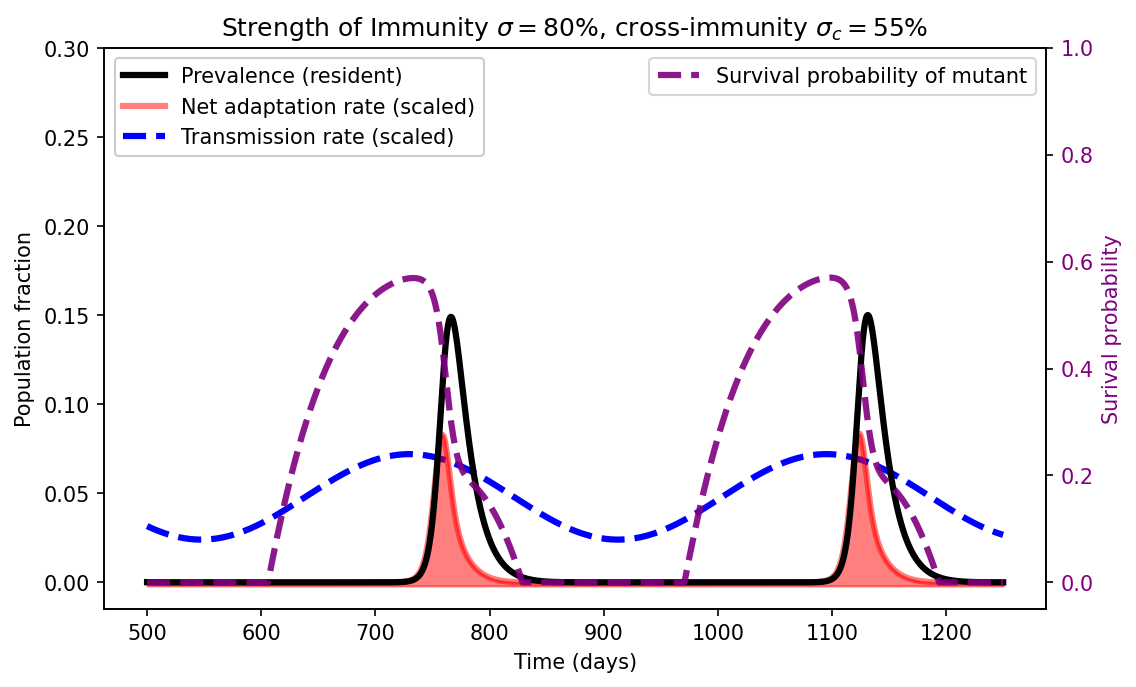

In [5]:
# Plotting the results
sigma_upscaled = int(sigma * 100)
sigma_c_upscaled = int(sigma_c * 100)

plt.figure(figsize=(1.62 * 5, 1.62 * 3), dpi=150)

ax1 = plt.gca()

imin = int(500/dt)
imax = int(1250/dt)

Iplotvar = I[imin:imax]/N

plt.plot(times[imin:imax], Iplotvar, label='Prevalence (resident)', color='black', linewidth=lw)

plt.plot(times[imin:imax], erates_plot_multiplier * erates[imin:imax], label='Net adaptation rate (scaled)', color="red", linewidth=lw, zorder=0, alpha=0.5)
ax1.fill_between(times[imin:imax], erates_plot_multiplier * erates[imin:imax], -0.002, color='red', alpha=.5)
#plt.plot(times, 1000*eSrs, '--', label='Effective susceptibles (resident) (scaled)', color="orange", linewidth=lw)
plt.plot(times[imin:imax], 0.12*betas[imin:imax], '--', label='Transmission rate (scaled)', color="blue", linewidth=lw, zorder=0)

ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Population fraction')
ax1.set_ylim([-0.015,np.max(Iplotvar)*2 ])

ax2 = ax1.twinx()
ax2.set_ylabel('Surival probability', color="purple")  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor="purple")
ax2.set_ylim([-0.05,1])
ax2.plot(times[imin:imax], omds[imin:imax], '--', label='Survival probability of mutant', color="purple", linewidth=lw, alpha=0.9, zorder=1)
#ax2.fill_between(times[imin:imax], omds[imin:imax], 0, color='purple', alpha=.1)

#plt.ylim([0,N])
plt.title(r'Strength of Immunity $\sigma=$' + f'{sigma_upscaled}%, cross-immunity ' + r'$\sigma_c=$' + f'{sigma_c_upscaled}%')
leg = ax1.legend(loc='upper left', facecolor='white', framealpha=1, frameon=True)
frame = leg.get_frame()
#frame.set_color('white')
leg.get_frame().set_facecolor('white')
leg.get_frame().set_alpha(0.7)
leg.set_zorder(102)
leg.remove()

frame.set_alpha(1)
ax2.legend(loc='upper right')
ax2.add_artist(leg)
plt.show()

# Fig 4B:

In [6]:
mu_ex = 0.01*mu # 0, 5e-2 * mu


N = 1000  # Total population
I0 = 1  # Initial number of infected individuals
S0 = N - I0  # Initial number of susceptible individuals
R0 = 0  # Initial number of recovered individuals
T = 1300  # Total time (1 year)
dt = 0.2  # Time step (1 day)

# Initialize arrays
times = np.arange(0, T+dt, dt)
S = np.zeros(len(times))
I = np.zeros(len(times))
R = np.zeros(len(times))
betas = np.zeros(len(times))


# Set initial conditions
S[0] = S0
I[0] = I0
R[0] = R0
beta_t = mean_beta + amplitude * np.cos(2 * np.pi * 0 / 365)  # Seasonal forcing of beta
betas[0] = beta_t

# Euler's method for numerical integration
for t in range(1, len(times)):
    beta_t = mean_beta + amplitude * np.cos(2 * np.pi * times[t] / 365)  # Seasonal forcing of beta
    betas[t] = beta_t
    S[t] = S[t-1] + dt * (-beta_t * S[t-1] * I[t-1] / N + delta * R[t-1])
    I[t] = I[t-1] + dt * (beta_t * S[t-1] * I[t-1] / N + beta_t * (1-sigma) * R[t-1] * I[t-1] / N - gamma * I[t-1])
    R[t] = R[t-1] + dt * (gamma * I[t-1] - delta * R[t-1] - beta_t * (1-sigma) * R[t-1] * I[t-1] / N)

# Given the parameters, compute the emergence rate for each timestep:
erates = np.zeros(len(times))
omds = np.zeros(len(times))
eSrs = np.zeros(len(times))
for t in range(len(times)):
    beta_t = betas[t]
    er, omd, eSr = get_em_rate(mu=mu, beta=beta_t, gamma=gamma, S=S[t]/N, R=R[t]/N, I=I[t]/N,
                               sigma=sigma, sigma_c=sigma_c, mu_ex=mu_ex)
    erates[t] = er
    omds[t] = omd
    eSrs[t] = eSr

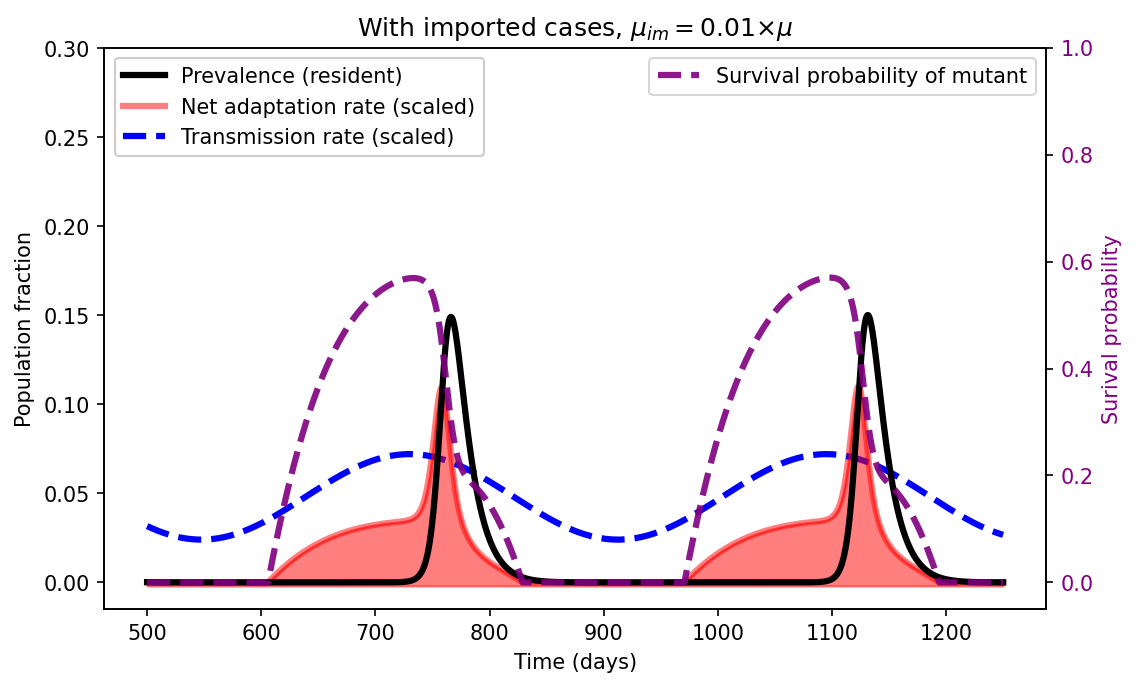

In [7]:
# Plotting the results
sigma_upscaled = int(sigma * 100)
sigma_c_upscaled = int(sigma_c * 100)

plt.figure(figsize=(1.62 * 5, 1.62 * 3), dpi=150)

ax1 = plt.gca()

imin = int(500/dt)
imax = int(1250/dt)

Iplotvar = I[imin:imax]/N

plt.plot(times[imin:imax], Iplotvar, label='Prevalence (resident)', color='black', linewidth=lw)

plt.plot(times[imin:imax], erates_plot_multiplier * erates[imin:imax], label='Net adaptation rate (scaled)', color="red", linewidth=lw, zorder=0, alpha=0.5)
ax1.fill_between(times[imin:imax], erates_plot_multiplier * erates[imin:imax], -0.002, color='red', alpha=.5)
#plt.plot(times, 1000*eSrs, '--', label='Effective susceptibles (resident) (scaled)', color="orange", linewidth=lw)
plt.plot(times[imin:imax], 0.12*betas[imin:imax], '--', label='Transmission rate (scaled)', color="blue", linewidth=lw, zorder=0)

ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Population fraction')
ax1.set_ylim([-0.015,np.max(Iplotvar)*2 ])

ax2 = ax1.twinx()
ax2.set_ylabel('Surival probability', color="purple")  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor="purple")
ax2.set_ylim([-0.05,1])
ax2.plot(times[imin:imax], omds[imin:imax], '--', label='Survival probability of mutant', color="purple", linewidth=lw, alpha=0.9, zorder=1)
#ax2.fill_between(times[imin:imax], omds[imin:imax], 0, color='purple', alpha=.1)

#plt.ylim([0,N])
plt.title(r'With imported cases, $\mu_{im}=$' + f'{np.round(mu_ex/mu,3)}' + r'$\times \mu$')
leg = ax1.legend(loc='upper left', facecolor='white', framealpha=1, frameon=True)
frame = leg.get_frame()
#frame.set_color('white')
leg.get_frame().set_facecolor('white')
leg.get_frame().set_alpha(0.7)
leg.set_zorder(102)
leg.remove()

frame.set_alpha(1)
ax2.legend(loc='upper right')
ax2.add_artist(leg)
plt.show()

# Fig 4C:

In [8]:
# Re-importing numpy and matplotlib after the code execution state reset
import numpy as np
import matplotlib.pyplot as plt

# Parameters
#mu_ex = 1e-4 # High
mu_ex = 0.01*mu # 

N = 1000  # Total population
T = 2000  # Total time (2 years)
dt = 0.2  # Time step (1 day)

# Initialize arrays
times = np.arange(0, T+dt, dt)
betas = np.zeros(len(times))
S = np.zeros(len(times))
I1 = np.zeros(len(times))
I2 = np.zeros(len(times))
R1 = np.zeros(len(times))
R2 = np.zeros(len(times))
I12 = np.zeros(len(times))
I21 = np.zeros(len(times))
R = np.zeros(len(times))

beta_t = mean_beta + amplitude * np.cos(2 * np.pi * times[0] / 365)  # Seasonal forcing of beta
betas[0] = beta_t

# Initial conditions
I1[0] = 1  # Initial number of infections with strain 1
I2[0] = 0  # Initial number of infections with strain 2
S[0] = N - I1[0] - I2[0]  # Initial number of susceptible individuals

# Euler's method for numerical integration
for t in range(1, len(times)):
    beta_t = mean_beta + amplitude * np.cos(2 * np.pi * times[t] / 365)  # Seasonal forcing of beta
    betas[t] = beta_t
    if times[t] == 650: # 2000, 2120 or ...
        print("Introducing new variant at t =", times[t])
        I2[t-1] = 1
    # Update compartments directly using the differential equations
    S[t] = S[t-1] + dt * (-beta_t * S[t-1] * (I1[t-1] + I12[t-1] + I2[t-1] + I21[t-1])/N + delta * (R1[t-1] + R2[t-1] + R[t-1]))
    I1[t] = I1[t-1] + dt * (beta_t * S[t-1] * (I1[t-1] + I12[t-1]) / N + beta_t * (1-sigma) * R1[t-1] * (I1[t-1] + I12[t-1]) / N - gamma * I1[t-1])
    I2[t] = I2[t-1] + dt * (beta_t * S[t-1] * (I2[t-1] + I21[t-1]) / N + beta_t * (1-sigma) * R2[t-1] * (I2[t-1] + I21[t-1]) / N - gamma * I2[t-1])
    R1[t] = R1[t-1] + dt * (gamma * I1[t-1] - delta * R1[t-1] - beta_t * (1-sigma) * R1[t-1] * (I1[t-1] + I12[t-1]) / N - beta_t * R1[t-1] * (I2[t-1] + I21[t-1]) / N)
    R2[t] = R2[t-1] + dt * (gamma * I2[t-1] - delta * R2[t-1] - beta_t * (1-sigma) * R2[t-1] * (I2[t-1] + I21[t-1]) / N - beta_t * R2[t-1] * (I1[t-1] + I12[t-1]) / N)
    I12[t] = I12[t-1] + dt * (beta_t * (1-sigma) * R[t-1] * (I1[t-1] + I12[t-1]) / N + beta_t * R2[t-1] * (I1[t-1] + I12[t-1]) / N - gamma * I12[t-1])
    I21[t] = I21[t-1] + dt * (beta_t * (1-sigma) * R[t-1] * (I2[t-1] + I21[t-1]) / N + beta_t * R1[t-1] * (I2[t-1] + I21[t-1]) / N - gamma * I21[t-1])
    R[t] = R[t-1] + dt * (gamma * (I12[t-1] + I21[t-1]) - delta * R[t-1] - beta_t * (1-sigma) * R[t-1] * (I1[t-1] + I12[t-1] + I2[t-1] + I21[t-1])/N )

# Plotting the results
#plt.figure(figsize=(12, 8))
#plt.plot(times, I1+I12, "--", label='Infected with Strain 1', linewidth=3)
#plt.plot(times, I2+I21, "--", label='Infected with Strain 2', linewidth=3)
#plt.plot(times, S, label='Susceptible')
#plt.plot(times, R1, label='Recovered from Strain 1')
#plt.plot(times, R2, label='Recovered from Strain 2')
#plt.plot(times, R, label='Recovered from Both Strains')
#plt.xlabel('Time (days)')
#plt.ylabel('Number of Individuals')
#plt.title('Two-Strain SIRS Model with Seasonal Forcing and Partial Immunity')
#plt.xlim([1000,3500])
#plt.legend()
#plt.show()

# Given the parameters, compute the emergence rate for each timestep:
erates = np.zeros(len(times))
omds = np.zeros(len(times))
eSrs = np.zeros(len(times))
for t in range(len(times)):
    beta_t = betas[t]
    #er, omd, eSr = get_em_rate(mu=1e-4, beta=beta_t, gamma=gamma, S=S[t]/N, R=R[t]/N, I=I[t]/N, sigma=sigma, mu_ex=1e-4)
    er, omd, eSr = get_em_rate_twostrain(mu, beta_t, gamma, S[t]/N, I1[t]/N, I2[t]/N, I12[t]/N, 
                                         I21[t]/N, R1[t]/N, R2[t]/N, R[t]/N, sigma, sigma_c, mu_ex)
    erates[t] = er
    omds[t] = omd
    eSrs[t] = eSr

# Plotting the results
sigma_upscaled = int(sigma * 100)
sigma_c_upscaled = int(sigma_c * 100)

Introducing new variant at t = 650.0


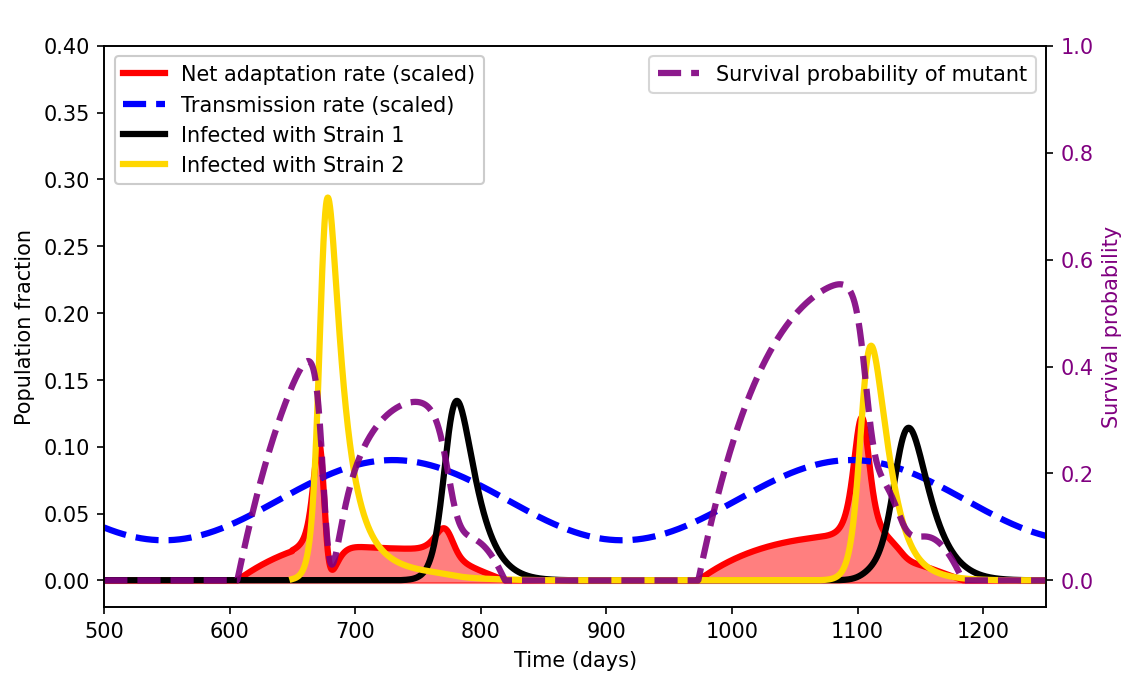

Max emergence rate: 0.050234538536158446


In [9]:
plt.figure(figsize=(1.62 * 5, 1.62 * 3), dpi=150)

#plt.plot(times, S, label='Susceptible')
lw = 3
when_to_plot_1 = ((I1+I12)>1e-1)
when_to_plot_2 = ((I2+I21)>1e-1)
#plt.plot(times, R, label='Recovered')
#plt.plot(times, S, label='Susceptible')
ax1 = plt.gca()

plt.plot(times, erates_plot_multiplier * erates, label='Net adaptation rate (scaled)', color="red", linewidth=lw, zorder=2)
ax1.fill_between(times, erates_plot_multiplier * erates, -0.002, color='red', alpha=.5, zorder=2)
#plt.plot(times, 1000*eSrs, '--', label='Effective susceptibles (resident) (scaled)', color="orange", linewidth=lw)
plt.plot(times, 0.15*betas, '--', label='Transmission rate (scaled)', color="blue", linewidth=lw)

plt.plot(times[when_to_plot_1], (I1+I12)[when_to_plot_1]/N, label='Infected with Strain 1', linewidth=lw, color='black', zorder=3)
plt.plot(times[when_to_plot_2], (I2+I21)[when_to_plot_2]/N, label='Infected with Strain 2', linewidth=lw, color='gold', zorder=4)

ax1.set_ylim([-0.02,0.4])

ax2 = ax1.twinx()
ax2.set_ylabel('Surival probability', color="purple")  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor="purple")
ax2.set_ylim([-0.05,1])
ax2.plot(times[imin:imax], omds[imin:imax], '--', label='Survival probability of mutant', color="purple", linewidth=lw, alpha=0.9, zorder=1)
#ax2.fill_between(times[imin:imax], omds[imin:imax], 0, color='purple', alpha=.1)

ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Population fraction')
ax2.set_ylabel('Survival probability')
#plt.ylim([0,])
plt.xlim([500,1250])
#plt.title(r'Leaky Immunity (Strength of Imm. $\sigma=$' + f'{sigma_upscaled}%, ' + r'$\sigma_c=$' + f'{sigma_c_upscaled}%)')
plt.title('  ')
ax2.legend(loc='upper right')
ax1.legend(loc='upper left')


leg = ax1.legend(loc='upper left', facecolor='white', framealpha=1, frameon=True)
frame = leg.get_frame()
#frame.set_color('white')
leg.get_frame().set_facecolor('white')
leg.get_frame().set_alpha(0.7)
leg.set_zorder(102)
leg.remove()

frame.set_alpha(1)
ax2.legend(loc='upper right')
ax2.add_artist(leg)

#plt.savefig(pngdir + "single.png", dpi=150)
plt.show()
print("Max emergence rate:", np.max(erates))